In [1]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum > /dev/null

In [0]:
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

In [0]:
#기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

1. 학습세트와 테스트세트를 7:3으로 임의로 나누기
1. 데이터 전처리
1. 단어 벡터화(BOW, TF-IDF)
1. 분류기 설정하기(Random Forest)
1. 분류기로 학습시키기
1. 학습의 정확도 보기
1. 테스트 데이터 예측하기
1. 실제 데이터와 예측결과의 차이를 보기

In [0]:
import pandas as pd
import numpy as np
import re

In [0]:
petitions = pd.read_csv("/content/drive/My Drive/colab/국민청원 데이터 분석/DATA/petition.csv", parse_dates=['start','end'])

In [5]:
petitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395547 entries, 0 to 395546
Data columns (total 8 columns):
article_id    395547 non-null int64
start         395547 non-null datetime64[ns]
end           395547 non-null datetime64[ns]
answered      395547 non-null int64
votes         395547 non-null int64
category      395547 non-null object
title         395547 non-null object
content       395546 non-null object
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 24.1+ MB


In [6]:
petitions.describe()

,article_id,answered,votes
count,395547.000000,395547.000000,3.955470e+05
mean,251608.934635,0.000073,1.501188e+02
std,153219.216242,0.008562,4.802583e+03
min,21.000000,0.000000,0.000000e+00
25%,115236.500000,0.000000,2.000000e+00
50%,253682.000000,0.000000,5.000000e+00
75%,386137.500000,0.000000,1.500000e+01
max,517122.000000,1.000000,1.192049e+06


In [0]:
# 전체 데이터 중 투표가 500건 이상인 데이터를 기준으로 가져옵니다.
df = petitions.loc[(petitions['votes'] > 500)].copy()

In [8]:
df.head()

,article_id,start,end,answered,votes,category,title,content
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...
13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된..."
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된..."
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...


In [0]:
category_count = df.category.value_counts()

In [10]:
category_count

인권/성평등         699
육아/교육          606
안전/환경          526
교통/건축/국토       503
보건복지           492
정치개혁           466
기타             444
문화/예술/체육/언론    308
행정             264
외교/통일/국방       261
일자리            250
경제민주화          191
반려동물           160
미래              86
성장동력            52
저출산/고령화대책       44
농산어촌            36
Name: category, dtype: int64

In [11]:
len(df['category'].unique())

17

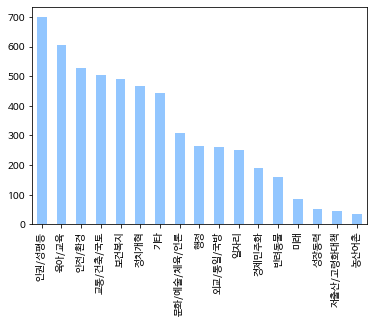

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
category_count.plot(kind='bar')

In [0]:
df = df[(df['category'] == '인권/성평등') |
        (df['category'] == '육아/교육') |
        (df['category'] == '문화/예술/체육/언론') |
        (df['category'] == '정치개혁')]

In [0]:
category_count = df['category'].value_counts()

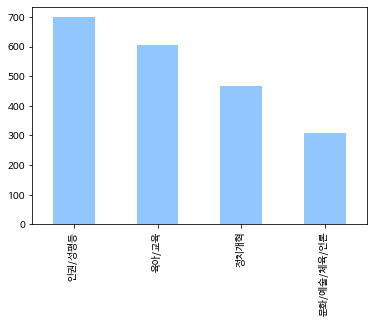

In [15]:
category_count.plot(kind='bar')

In [0]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['category_pred'] = df['category'].copy()

In [0]:
sample_index = df.iloc[0].name

In [0]:
sample_title = df.loc[sample_index, 'title']

In [0]:
sample_content = petitions['content'][sample_index]

# 전처리 하기
+ 특수문자 제거
+ 개행문자 제거
+ 불용어 처리

In [0]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ]', ' ', text)
    return text

In [0]:
#불용어 제거
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

# 샘플 데이터에 먼저 적용해보기

In [0]:
pre_sample_content = preprocessing(sample_content)

In [0]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [24]:
pre_sample_content

'대통령님  안녕하세요  임용을 준비하고 수험생입니다  처음 기간제 정규직화 된다고 했을 때  공채 채용과정이 있는데  설마 그러겠어라고 생각하고 있었습니다  기간제는 채용과정이 공개채용에 비해 불투명하고  아이들을 가르칠 전문성이 떨어지는데  어떻게 된다는 거지  그런 생각이라 사실 그냥 뜬 소문이라고 생각했습니다  수년간 임용을 준비하는 수험생으로서  여러 기회비용을 포기하고  오로지 교단에서 서서 아이들에게 내가 알고 지식을 제대로 가르치겠다는 신념으로 공부해왔습니다  그런데 오늘 보니 기간제가 정규직화되는 것이 거의 확정적으로 되는 것같아  사실 너무 상대적 허탈감을 느낍니다  기간제 선생님들은 임용고시를 일단 보류해두고 현장에 나아간 것이고  임용 준비생은 일단 임용고시 합격을 목표로 한해 기회비용까지 써가면서 공부하는 것이니까요  그래서 전문적인 지식을 갖추고 임용수험생들이 현장에 일하지 않았다는 이유로 기간제 교사에게 기회까지 박탈당하면서 자리를 내주어야 하나 의구심이 듭니다  존경하는 대통령님 기간제 정규직화 다시 한번 생각해주시기 바랍니다  양질의 아이들에게 교육을 제공하기 위해서라도  기간제 정규직화는 안됩니다  똑같은 기회의 평등을 제공해주십시오  전문적인 지식을 갖추고 열심히 노력한 임고생이 단지 현장을 경험하지 않았다는 이유만으로 역차별을 당하는 일은 없어야  미래의 아이들을 가르칠 인력  다시 한번 심사숙고해주시길 바랍니다  나라를 이끌어갈 인재를 양성하는 곳입니다  제발  다시한번 시사숙고 해주시길 바랍니다  사대와 교대를 폐지하고 로스쿨화시킨다고 글을 카페에서 읽었습니다  제발 사실이 아니길 기도합니다  현대판 음서제를 시행하는 것이라고 비판하더라군요  또한 교육개혁에 교사의 지방직화라는 글을 들었습니다  처음에는 그냥 설마겠거니 했습니다  그런데 점차그렇게 흘러가는 것 같더군요  나라의 재정이 어려워  공무원 연금을 삭감하기 기간제를 무기계약직으로 채용하는 것이라면  그게 시작이라면 어쩔 없다고 생각합니다  하지만 의원님  교육의

# 전체 데이터에 적용하기

In [98]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 150 ms, sys: 1.95 ms, total: 152 ms
Wall time: 155 ms


In [99]:
%time df['content_preprocessing'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 276 ms, sys: 2.99 ms, total: 279 ms
Wall time: 282 ms


In [0]:
df = df.reindex()

In [101]:
df.shape

(2079, 10)

In [102]:
split_count = int(df.shape[0] * 0.7)
split_count

1455

In [0]:
df_train = df[:split_count].copy()

In [104]:
df_train.shape

(1455, 10)

In [0]:
df_test = df[split_count:].copy()

In [106]:
df_test.shape

(624, 10)

# 카테고리
+ 학습 세트의 카테고리 보기

In [0]:
df_train_category_value = pd.DataFrame(df_train['category'].value_counts())

In [0]:
df_train_category_percent = pd.DataFrame(df_train['category'].value_counts(normalize=True))

In [0]:
df_train_category = df_train_category_value.merge(df_train_category_percent, left_index=True, right_index=True)

In [0]:
df_train_category.columns = ['청원수', '청원비율']

In [111]:
df_train_category

,청원수,청원비율
인권/성평등,468,0.321649
육아/교육,386,0.265292
정치개혁,366,0.251546
문화/예술/체육/언론,235,0.161512


In [0]:
df_test_category_value = pd.DataFrame(df_test['category'].value_counts())

In [0]:
df_test_category_percent = pd.DataFrame(df_test['category'].value_counts(normalize=True))

In [0]:
df_test_category = df_test_category_value.merge(df_test_category_percent,left_index=True, right_index=True)

In [0]:
df_test_category.columns = ['청원수','청원비율']

In [116]:
df_test_category

,청원수,청원비율
인권/성평등,231,0.370192
육아/교육,220,0.352564
정치개혁,100,0.160256
문화/예술/체육/언론,73,0.116987


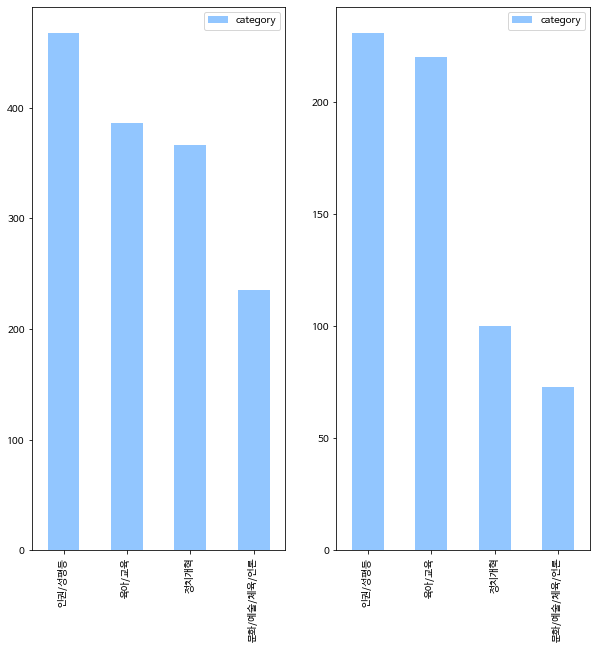

In [117]:
f, ax = plt.subplots(1,2, figsize=(10,10))
df_train_category_value.plot(kind='bar',ax=ax[0])
df_test_category_value.plot(kind='bar',ax=ax[1])

# 단어 벡터화 하기
+ BOW(Bag of Words)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
stops = ['and', 'article', 'html', '수', '현', '있는', '있습니다', 
         '그', '년도', '합니다', '하는', '및', '제', '할', '하고', 
         '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', 
         '등', '일', '많은', '이런', '것은', 
         '왜','같은', '같습니다', '없습니다', '위해', '한다', 'articles', 'articleview', 'articleview idxno',
         'asp','a는','cctv','cctv를','co','co kr','aid','com','com main', 
         'com main read','com news','eb','ec','go','go kr','go kr petitions']

In [0]:
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )

In [121]:
%%time
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing'])
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['idxno', 'kr', 'main', 'news', 'petitions', 'read'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 4.49 s, sys: 70.6 ms, total: 4.56 s
Wall time: 4.57 s


In [0]:
vocab = vectorizer.get_feature_names()

In [123]:
vocab[:10]

['가게', '가고', '가까운', '가는', '가능성이', '가능한', '가량', '가만히', '가면', '가산점']

In [124]:
dist = np.sum(train_feature_vector, axis=0)
pd.DataFrame(dist, columns=vocab)

,가게,가고,가까운,가는,가능성이,가능한,가량,가만히,가면,가산점,가서,가슴을,가슴이,가운데,가장,가정,가정을,가정의,가져,가족,가족은,가족이,가지,가지고,가지는,가진,가짜,가치를,가해,가해자,가해자가,가해자는,가해자들은,가해자들을,가해자들이,가해자로,가해자를,가해자에게,가해자와,가해자의,...,현장을,현재,현재까지,현재는,현지,현직,현행,혈세를,혐오,협박,협박을,형사,형을,혜택을,호계,혹시,혹시나,혹은,혼란을,혼자,혼자서,홀로,홍대,화가,화를,확대,확실한,확인,확인하고,활동을,회사,회사는,회사의,후에,훨씬,힘든,힘들게,힘듭니다,힘을,힘이
0,34,23,21,49,43,57,22,28,36,32,41,28,39,306,37,35,23,36,27,28,91,158,88,24,30,26,82,54,41,26,23,30,38,120,88,35,25,48,22,26,...,22,29,525,21,30,52,34,44,33,28,21,23,30,29,26,33,110,22,57,46,23,33,29,25,32,21,27,33,29,34,24,30,22,52,33,75,44,22,46,38


TF-IDF 로 가중치 적용하기

In [126]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False, use_idf=True)

In [128]:
%%time
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 7 ms, sys: 93 µs, total: 7.09 ms
Wall time: 12.5 ms


In [129]:
%%time
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 6.72 ms, sys: 80 µs, total: 6.8 ms
Wall time: 8.6 ms


# 랜덤 포레스트로 학습시키기

In [132]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2019)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2019, verbose=0,
                       warm_start=False)

In [134]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
y_label = df_train['category']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 1.41 s, sys: 23.5 ms, total: 1.44 s
Wall time: 860 ms


# 학습이 잘 되었는지 평가하기

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

In [146]:
scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_tfidf, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

CPU times: user 44.6 ms, sys: 43 ms, total: 87.6 ms
Wall time: 4.75 s


array([0.64948454, 0.62199313, 0.63917526, 0.72164948, 0.73195876])

In [147]:
round(np.mean(score)*100,2)

67.29

# 예측

In [148]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_tfidf)
y_pred[:3]

array(['정치개혁', '정치개혁', '인권/성평등'], dtype=object)

In [149]:
y_pred.shape

(624,)

In [151]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head()

,category_pred
0,정치개혁
1,정치개혁
2,인권/성평등
3,인권/성평등
4,인권/성평등


In [152]:
# 0과 1이 어떻게 집계 되었는지 확인합니다.
output['category_pred'].value_counts()

정치개혁           217
인권/성평등         215
육아/교육          171
문화/예술/체육/언론     21
Name: category_pred, dtype: int64

In [0]:
df_test['category_pred'] = y_pred

# 예측결과 미리보기

In [154]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['category'] == df_test['category_pred']) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,pred_diff
261424,339460,2018-08-13,2018-09-12,0,10440,인권/성평등,홍대 공연음란남 몰카 징역 10월 선고가 말이 되나?,홍대 공연음란남의 피해자에게 1심에서 징역 10월이 선고되었다. 이게 말이 되는 것...,정치개혁,홍대 공연음란남의 피해자에게 심에서 징역 월이 선고되었다 이게 말이 되는 것...,0
261635,339785,2018-08-13,2018-09-12,0,651,인권/성평등,홍대몰카녀 더 강력한 처벌을 해주세요.,홍대 몰카녀는 몰카를 찍고 공유해서 대규모 사이트들에서 조롱까지 했습니다. 거기다 ...,정치개혁,홍대 몰카녀는 몰카를 찍고 공유해서 대규모 사이트들에서 조롱까지 했습니다 거기다 ...,0
261728,339919,2018-08-13,2018-09-12,0,7915,인권/성평등,내 딸의 억울한 죽음을 꼭 밝혀 주세요,저희 아이는 2017년 8월 5일에 이틀을 사경을 헤메다 세상을 떠났습니다...\n...,인권/성평등,저희 아이는 년 일에 이틀을 사경을 헤메다 세상을 떠났습니다 ...,1
263066,341703,2018-08-14,2018-09-13,0,1943,인권/성평등,묻지마폭행을 당하고 가해자로 처벌받게되었습니다. 너무억울합니다.,사건은 올해 2월15일 새벽1시가 조금 넘은 시각이었습니다. 이자까야에서 요리사로 ...,인권/성평등,사건은 올해 새벽 시가 조금 넘은 시각이었습니다 이자까야에서 요리사로 일을하며...,1
263837,342753,2018-08-15,2018-09-14,0,588,육아/교육,김포 아동학대 사건을 저지른 원장과 교사를 고발합니다.,저는 피해아동의 외할머니입니다.\n저희 손주는 5세 남아로 김포 장기동 **** 어...,인권/성평등,피해아동의 외할머니입니다 저희 손주는 세 남아로 김포 장기동 어린이집 ...,0


In [0]:
# 맞게 예측된 청원은 1, 틀린예측은 0으로 표기되었습니다.
pred_diff = df_test['pred_diff'].value_counts()

In [157]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[1]))

전체 624건의 데이터 중 275건 예측


In [167]:
acc = (pred_diff[1]/y_pred.shape[0]) *100
print('예측 비율 {}'.format(acc))

예측 비율 44.07051282051282


In [0]:
# 제대로 예측한 카테고리 데이터를 봅니다.
predict_correct = df_test.loc[df_test['pred_diff'] == 1]

In [170]:
predict_correct.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,pred_diff
261728,339919,2018-08-13,2018-09-12,0,7915,인권/성평등,내 딸의 억울한 죽음을 꼭 밝혀 주세요,저희 아이는 2017년 8월 5일에 이틀을 사경을 헤메다 세상을 떠났습니다...\n...,인권/성평등,저희 아이는 년 일에 이틀을 사경을 헤메다 세상을 떠났습니다 ...,1
263066,341703,2018-08-14,2018-09-13,0,1943,인권/성평등,묻지마폭행을 당하고 가해자로 처벌받게되었습니다. 너무억울합니다.,사건은 올해 2월15일 새벽1시가 조금 넘은 시각이었습니다. 이자까야에서 요리사로 ...,인권/성평등,사건은 올해 새벽 시가 조금 넘은 시각이었습니다 이자까야에서 요리사로 일을하며...,1
264152,343236,2018-08-15,2018-09-14,0,507,육아/교육,어린이집학부모 모니터링과 평가인증 없애야한다고 생각합니다 .,안녕하세요 저는 4세아들과7개월넘은 두아들을 키우고 잇습니다. 두아들이 다니는 어린...,육아/교육,안녕하세요 세아들과 개월넘은 두아들을 키우고 잇습니다 두아들이 다니는 어린이집에...,1
264652,343870,2018-08-16,2018-09-15,0,1371,정치개혁,시민단체수준인 여가부 폐지를 청원합니다,http://www.edaily.co.kr/news/news_detail.asp?n...,정치개혁,...,1
264896,344174,2018-08-16,2018-09-15,0,698,인권/성평등,** 톨게이트 사무장의 부정행위 및 갑질 폭언을 고발합니다.,안녕하세요 저는 **톨게이트에서 주임으로 근무하는 사람 입니다.\n여기에 이런글을 ...,인권/성평등,안녕하세요 톨게이트에서 주임으로 근무하는 사람 여기에 이런글을 올리기까지 고민...,1


# 잘못 예측한 카테고리 보기

In [0]:
predict_incorrect = df_test.loc[df_test['pred_diff'] == 0].copy()

In [175]:
predict_incorrect.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,pred_diff
261424,339460,2018-08-13,2018-09-12,0,10440,인권/성평등,홍대 공연음란남 몰카 징역 10월 선고가 말이 되나?,홍대 공연음란남의 피해자에게 1심에서 징역 10월이 선고되었다. 이게 말이 되는 것...,정치개혁,홍대 공연음란남의 피해자에게 심에서 징역 월이 선고되었다 이게 말이 되는 것...,0
261635,339785,2018-08-13,2018-09-12,0,651,인권/성평등,홍대몰카녀 더 강력한 처벌을 해주세요.,홍대 몰카녀는 몰카를 찍고 공유해서 대규모 사이트들에서 조롱까지 했습니다. 거기다 ...,정치개혁,홍대 몰카녀는 몰카를 찍고 공유해서 대규모 사이트들에서 조롱까지 했습니다 거기다 ...,0
263837,342753,2018-08-15,2018-09-14,0,588,육아/교육,김포 아동학대 사건을 저지른 원장과 교사를 고발합니다.,저는 피해아동의 외할머니입니다.\n저희 손주는 5세 남아로 김포 장기동 **** 어...,인권/성평등,피해아동의 외할머니입니다 저희 손주는 세 남아로 김포 장기동 어린이집 ...,0
264979,344281,2018-08-16,2018-09-15,0,2680,육아/교육,경기도 시흥시 모고등학교 갑질 교감에 대한 중징계를 청원합니다.,대기업 오너 일가들의 ‘갑질’ 문제가 사회적으로 크게 이슈가 되고 있습니다.\n그러...,인권/성평등,대기업 오너 일가들의 갑질 문제가 사회적으로 크게 이슈가 되고 그러나 비단 ...,0
266273,345866,2018-08-18,2018-09-17,0,923,문화/예술/체육/언론,방통위원장 교체와 최기화 김도인 방문진이사 선임 취소,촛불의 염원으로 세워진 새로운 문재인 정부 그리고 문재인 대통령이 임명한 이효성 방...,인권/성평등,촛불의 염원으로 세워진 새로운 문재인 정부 문재인 대통령이 임명한 이효성 방송통신위...,0


In [177]:
predict_incorrect_value = predict_incorrect['category'].value_counts()
predict_incorrect_value

인권/성평등         123
육아/교육          115
문화/예술/체육/언론     72
정치개혁            39
Name: category, dtype: int64

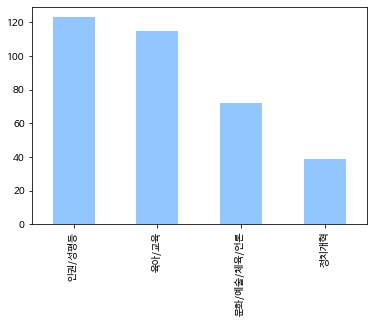

In [178]:
predict_incorrect_value.plot(kind='bar')

# 왜 예측 정확도가 낮을까요??
+ 청원을 입력하는 사람마다 카테고리 분류 기준이 정확하지 않은 것 같습니다.
+ 기타로 예측한 분류도 특정 카테고리로 분류해도 될 것으로 보여집니다.

In [179]:
predict_incorrect[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
261424,인권/성평등,정치개혁,홍대 공연음란남 몰카 징역 10월 선고가 말이 되나?,홍대 공연음란남의 피해자에게 1심에서 징역 10월이 선고되었다. 이게 말이 되는 것...
261635,인권/성평등,정치개혁,홍대몰카녀 더 강력한 처벌을 해주세요.,홍대 몰카녀는 몰카를 찍고 공유해서 대규모 사이트들에서 조롱까지 했습니다. 거기다 ...
263837,육아/교육,인권/성평등,김포 아동학대 사건을 저지른 원장과 교사를 고발합니다.,저는 피해아동의 외할머니입니다.\n저희 손주는 5세 남아로 김포 장기동 **** 어...
264979,육아/교육,인권/성평등,경기도 시흥시 모고등학교 갑질 교감에 대한 중징계를 청원합니다.,대기업 오너 일가들의 ‘갑질’ 문제가 사회적으로 크게 이슈가 되고 있습니다.\n그러...
266273,문화/예술/체육/언론,인권/성평등,방통위원장 교체와 최기화 김도인 방문진이사 선임 취소,촛불의 염원으로 세워진 새로운 문재인 정부 그리고 문재인 대통령이 임명한 이효성 방...
267335,육아/교육,정치개혁,초등학생 중학생 등 미성년자의핸드폰중독으로 인한 불법사이트노출 교통사고등등 사회문제...,초등 중등 핸드폰 개통불가와 폴더폰으로 할수있도록\n정부및 통신사에서\n도움 꼭 ...
269527,정치개혁,인권/성평등,혜경궁 김씨 정체는 언제 나옵니까? 국제파를 비롯한 이재명 은수미의 의혹들은 언제 ...,도대체 혜경궁 김씨 수사 결과는 언제 나오는 것입니까?\n트위터의 계정 정보를 그렇...
269996,육아/교육,문화/예술/체육/언론,장애영유아의 운명을 바꾸어 주세요! 장애유아에게 의무교육은 생존의 문제입니다!!,장애 영유아의 운명을 바꾸어주세요!\n장애유아에게 의무교육은 생존의 문제입니다!\n...
270428,육아/교육,정치개혁,"〓 국민특명, 전국 초․중․고 즉각 휴교실시 〓",전국 초․중․고교의 교장님들!\n고리타분한 노인네 티내지 마시고 당장 내일부터 태풍...
271486,정치개혁,인권/성평등,어머니를 도 뺑소니로 돌아가시게 한 범인을 13일만에 잡았는데 도주의 우려가 없다는...,사랑하는 어머니를 잃은 아들입니다.\n자식과 손녀와 오래오래 건강하게 사신다며 3년...


# 원래 데이터 중 분류기가 다르게 예측한 특정 카테고리 청원을 봅니다.

In [180]:
predict_incorrect_etc = predict_incorrect.loc[predict_incorrect['category'] == '육아/교육'].copy()
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
263837,육아/교육,인권/성평등,김포 아동학대 사건을 저지른 원장과 교사를 고발합니다.,저는 피해아동의 외할머니입니다.\n저희 손주는 5세 남아로 김포 장기동 **** 어...
264979,육아/교육,인권/성평등,경기도 시흥시 모고등학교 갑질 교감에 대한 중징계를 청원합니다.,대기업 오너 일가들의 ‘갑질’ 문제가 사회적으로 크게 이슈가 되고 있습니다.\n그러...
267335,육아/교육,정치개혁,초등학생 중학생 등 미성년자의핸드폰중독으로 인한 불법사이트노출 교통사고등등 사회문제...,초등 중등 핸드폰 개통불가와 폴더폰으로 할수있도록\n정부및 통신사에서\n도움 꼭 ...
269996,육아/교육,문화/예술/체육/언론,장애영유아의 운명을 바꾸어 주세요! 장애유아에게 의무교육은 생존의 문제입니다!!,장애 영유아의 운명을 바꾸어주세요!\n장애유아에게 의무교육은 생존의 문제입니다!\n...
270428,육아/교육,정치개혁,"〓 국민특명, 전국 초․중․고 즉각 휴교실시 〓",전국 초․중․고교의 교장님들!\n고리타분한 노인네 티내지 마시고 당장 내일부터 태풍...
274656,육아/교육,인권/성평등,장애아의 형제에게도 맞벌이 가정과 같이 어린이집 대기순번 가산점 부여 및 병설유치원...,만 4세 발달장애 아동과 만 2세 비장애 아동 아이 둘을 키우고 있는 아버지입니다....
274951,육아/교육,인권/성평등,현 고1도 진로선택과목 절대평가실시를 원합니다.,현 고1도 진로선택과목 절대평가실시를 원합니다.\n현 고1부터 적용되고 있는 201...
275096,육아/교육,인권/성평등,내아이는 안양동초등학교에 다니고있습니다,내아이는 안양동초등학교에 다니고있습니다\n그리고 졸업을 하겠지요\n또한 작은아이도 ...
275217,육아/교육,인권/성평등,아동학대 처벌.자격박탈. 왜 불가능한가요,안녕하세요\n저희는 인천 남동구 아동학대 건으로 남동구청과 남동서에 신고하여 조사가...
275307,육아/교육,인권/성평등,부천 옥길동에 유치원 초등학교 신설 좀 해주세요,정부는 다양한 저출산 대책을 시행해 왔는데 점점 아이는 줄어들고 있습니다 그런데 아...


# 예측 비율을 높이기위해 해볼 수 있는 것 들입니다.
+ 학습 세트와 테스트 세트의 비율을 7:3으로 유지하면서 다음과 같은 방법을 해봅시다.
+전처리하기
+불용어처리하기
+벡터 기법에 들어가는 파라미터 변경
+분류기의 파라미터 변경
+분류기변경